<font size=7> Latencies Analysis

# get pairs

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist, plot_vector_layout5, plot_vector_layout1, arrow_check, arrow_check2
from human_hip.animate import animate_latencies

from scipy import stats
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
import numpy as np
from human_hip.spike_data import latencies



In [2]:
with open('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/5-10-23s1-CutData.pkl', 'rb' ) as my_file:
    sd = pickle.load(my_file)

In [3]:

import numpy as np
from human_hip.spike_data import latencies, cross_sttc


def curate_latencies(sd,  latency_ms=30, sttc_cutoff = 0, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  #latency= np.median(pair_latencies)
        if len(pair_latencies)>=min_latencies and abs(np.mean(pair_latencies))> latency_cutoff :
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=latency_ms) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>=min_latencies:
                    t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                    if p_value < pval:
                        pairs_late.append( [ pair[1], pair[0] ] )
            else:
                t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                if p_value < pval:
                    pairs_late.append( pair )
    print( len(pairs_late), "pairs above latencency cutoff")

    mean_latencies = []
    for pair in pairs_late:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_late

In [4]:
latency_ms = 30
good_pairs = curate_latencies(sd, latency_ms=30, sttc_cutoff = 0.01, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ) 

# latency_ms = 15
# good_pairs = curate_latencies(sd,  latency_ms=latency_ms, sttc_cutoff = 0.02, latency_cutoff=1, sttc_delta=20, pval=.05 ) 

good_pairs2 = np.array(good_pairs)



10000 Starting Pairs
2551 pairs above sttc cutoff
92 pairs above latencency cutoff
all final pairs positive?: True


In [5]:
#good_pairs
print( len(good_pairs), "good pairs" )

mean_latencies = []
for pair in good_pairs:
    mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
    mean_latencies.append(mean_latency)
print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

92 good pairs
all final pairs positive?: True


# make plots

all final pairs positive?: True


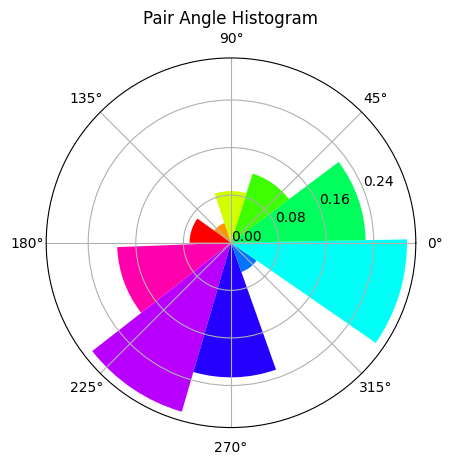

In [6]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=False, late_cutoff_high=latency_ms)

all final pairs positive?: True


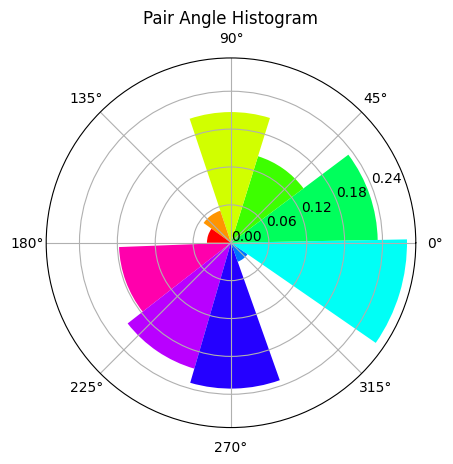

In [7]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True, late_cutoff_high=latency_ms)

Pairs removed by SD cutoff: 2
Total Final Pairs: 19


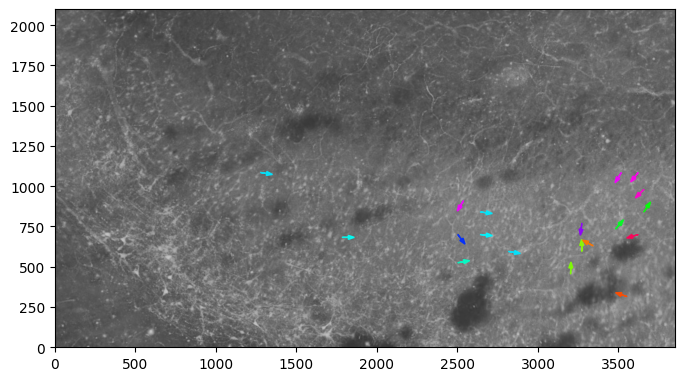

In [9]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc52_bw4.png", 
                    figsize=(8, 8), #xlim=(1800,3800), ylim=(0,1500),
                   sd_cuttoff=1 , latency_ms=30 )

# <font color="brown"> Rotate Angle Histogram

In [25]:


def plot_latency_angle_hist( sd, pairs, by_firing_rate=False, late_cutoff_low=1, late_cutoff_high=15):
    """
    Inputs:
        sd: SpikeData object
        pairs: np.array of neuron indices (as pairs) for which a connection exists, ex: [[0,1], [0,2], [2,3]]
        by_firing_rate: boolean, if True, the angle histogram will be weighted by the number of latencies for each pair
        late_cutoff_low: integer, the lower bound of the latency cutoff
        late_cutoff_high: integer, the upper bound of the latency cutoff
    Outputs:
        A plot depicting the histogram of the angles of the pairs
    """
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][1], 3850 - neuron['position'][0]] )
        #neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    mean_latencies = []
    for pair in pairs:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=late_cutoff_high)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

    # make pairs point in same direction
    #pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.mean(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=late_cutoff_high))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]
            print("WARNING: Some Latency pairs switched")

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ [pair[0] for pair in pairs] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ [pair[1] for pair in pairs] ]
    angle = np.arctan2(-(ends[:,1]-starts[:,1]), ends[:,0]-starts[:,0]) * -1

    if by_firing_rate:
        latency_counts = []
        for pair in pairs:
            latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_low=late_cutoff_low, ms_cutoff_high=late_cutoff_high, positive_only=True )) )
        latency_counts= np.array(latency_counts)
        angle = np.repeat( angle, latency_counts )

    #n_bins = 30  # You can adjust the number of bins here
    counts, bin_edges = np.histogram(angle,  density=True)  #bins=n_bins,
    bin_width = np.diff(bin_edges)
    cmap = cm.get_cmap('hsv')
    bin_angles= (bin_edges[:-1] - bin_edges.min()) / (bin_edges.max() - bin_edges.min())
    bin_angles = bin_angles[::-1] #+ .05
    bin_colors = cmap(bin_angles)

    ax = plt.subplot(111, polar=True)
    for idx, count in enumerate(counts):
        ax.bar(bin_edges[idx], count, width=bin_width[idx], color=bin_colors[idx], align='edge')
    #ax.set_yticks([0,.1,.2,.3,.4])
    ax.yaxis.set_major_locator(MaxNLocator(5))
    plt.title('Connection Angle Histogram')
    plt.show()


/tmp/ipykernel_58793/2214295080.py:13: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


all final pairs positive?: True


/tmp/ipykernel_58793/2214295080.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


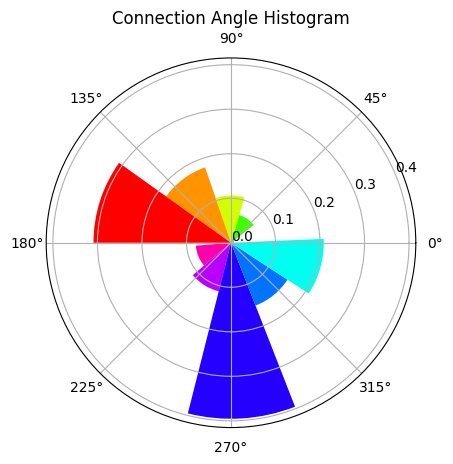

In [26]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True, late_cutoff_high=latency_ms)

# <font color="brown"> Rotate  Vector Plot

In [10]:

from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual
from matplotlib.ticker import MaxNLocator


In [21]:
# helper functions
def rotate_angles( angles, add=1):
    adjusted_angles = []
    for num in angles:
        num += add         # Add 1 to the number
        adjusted_num = ((num + math.pi) % (2 * math.pi)) - math.pi  # modulo operation to wrap within -pi to pi
        adjusted_angles.append(adjusted_num)
    return adjusted_angles

def rotated_sd( angles ):
    sds = []
    for i in range(-3,1): #[-3,1]
        sds.append( np.std( rotate_angles(angles, add=i), ddof=1) )
    return min(sds)

def rotated_mean( angles ):
    sds = []
    means = []
    for i in range(-3,1): #[-3,1]
        new_angles = rotate_angles(angles, add=i)
        sds.append( np.std( new_angles, ddof=1) )
        new_mean = np.mean(new_angles) - i 
        adjusted_mean = ((new_mean + math.pi) % (2 * math.pi)) - math.pi
        means.append( adjusted_mean   ) 
    return means[np.argmin(sds)]

################
# Main Code
def plot_vector_layout5( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, 
                         sd_cuttoff=100 , latency_ms=30):

    # make sure all latencies have positive mean
    # pairs = pairs    # ?avoid bug? 
    # mean_latencies = []
    # for pair in pairs:
    #     mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
    #     mean_latencies.append(mean_latency)
    # print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][1], 3850 - neuron['position'][0]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count                  
    latency_counts = []
    for pair in pairs:
        latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_high=latency_ms, positive_only=True )) )

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ [pair[0] for pair in pairs] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ [pair[1] for pair in pairs] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latency_counts[i]
        else:
            pair_dict[key] = [ angles[i] ] * latency_counts[i]

    # create new dictionary of just mean angles
    pair_angles = {}
    pair_sd = {}
    for key, value in pair_dict.items():
        pair_angles[key] =  rotated_mean( value ) #sum(value) / len(value)
        pair_sd[key] = rotated_sd( value ) #/ len(value)

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 2100, 0 ,3850]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    pair_final = 0
    for pair, angle in pair_angles.items():
        if pair_sd[pair] < sd_cuttoff :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
            pair_final = pair_final + 1
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SD cutoff:", pair_removed )
    print("Total Final Pairs:", pair_final )

    

/tmp/ipykernel_58793/3671473861.py:42: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_58793/3671473861.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 2
Total Final Pairs: 19


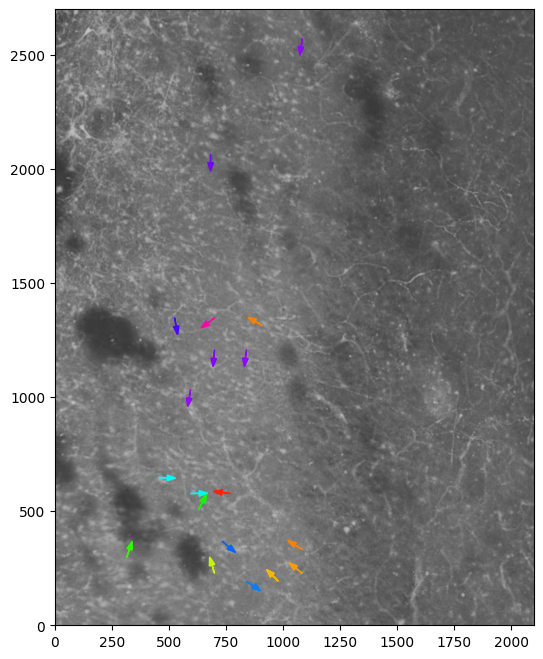

In [29]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc52_bw4_rotated.png", 
                    figsize=(8, 8),  ylim=(0,2700), #xlim=(1800,3800),
                   sd_cuttoff=1 , latency_ms=30 )